## Импорты

стандартные библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import chardet

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px

дополнительные импорты

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

чтобы никто не осуждал

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Базовая информация о датасете

*название изменил, чтобы не возникло ошибок из-за кириллицы в path к файлу

In [4]:
data_path = "lollipops.dat"

предположу, что не знаю кодировку и у меня есть только информация из задания о названиях классов (V1, ... V2)

- чтобы определить кодировку можно использовать библиотеку `chardet`

In [5]:
with open(data_path, 'rb') as f:
    result = chardet.detect(f.read())
encoding = result['encoding']

- разделители просто переберём

In [6]:
for sep in ['\t', ';', ',', ' ']:
    try:
        df = pd.read_csv(data_path, sep=sep, encoding=encoding)
        if df.shape[1] >= 5:
            break
    except Exception:
        continue

для наибольшего понимания о формате датасета:

In [7]:
df.shape

(338, 11)

In [8]:
list(df.columns)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']

проверим на отсутствие пустых ячеек в столбцах

In [9]:
df.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
dtype: int64

In [10]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
0,4,5,5,5,3,3,3,3,3,3,3
1,5,4,5,5,3,3,3,3,3,3,3
2,5,5,4,5,3,3,3,3,3,3,3
3,5,4,5,5,3,3,3,3,3,3,3
4,4,5,5,5,3,3,3,3,3,3,3


Получим основную статистику по датасету, исполmpez `.describe`. Здесь:
- `count` — количество непустых значений,
- `mean` — среднее,
- `std` — стандартное отклонение,
- `min` — минимум,
- `25%`, `50%`, `75%` — квартильные значения,
- `max` — максимум.

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,338.0,3.544379,0.955748,2.0,3.0,3.0,5.0,5.0
V2,338.0,3.526627,0.956410,2.0,3.0,3.0,5.0,5.0
V3,338.0,3.517751,0.990150,2.0,3.0,3.0,5.0,5.0
V4,338.0,3.411243,0.992311,2.0,3.0,3.0,4.0,5.0
V5,338.0,3.207101,0.867314,2.0,3.0,3.0,3.0,5.0
V6,338.0,3.204142,0.869725,2.0,3.0,3.0,3.0,5.0
V7,338.0,3.254438,0.844107,2.0,3.0,3.0,3.0,5.0
V8,338.0,3.289941,0.821784,2.0,3.0,3.0,3.0,5.0
V9,338.0,3.603550,0.969682,2.0,3.0,3.0,5.0,5.0
V10,338.0,3.550296,0.927082,2.0,3.0,3.0,5.0,5.0


Из статистики, приведённой выше, можно заметить, что наиболее выражены цели употребления леденцов, соответствующие классам `V1`, `V2`, `V3`, `V9`, `V10`, `V11`, т.е. люди употребляют леденцы по практическим причинам (дыхание, здоровье). Так, например, значение `mean` для `V9` = 60 (самый высокий показатель). Это  соответствует тому, что люди часто покупают леденцы в сезон простуд, даже без рецепта.

## Визуализация распределения оценок

[Виды графиков](https://matplotlib.org/stable/plot_types/index.html) в matplotlib

Чтобы понять насоклько распределены мнения, где оценки "скучены" вокруг одного знеачения, построим составную столбчатую диаграмму

*цвета выбирал, основываясь на [палитрах](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

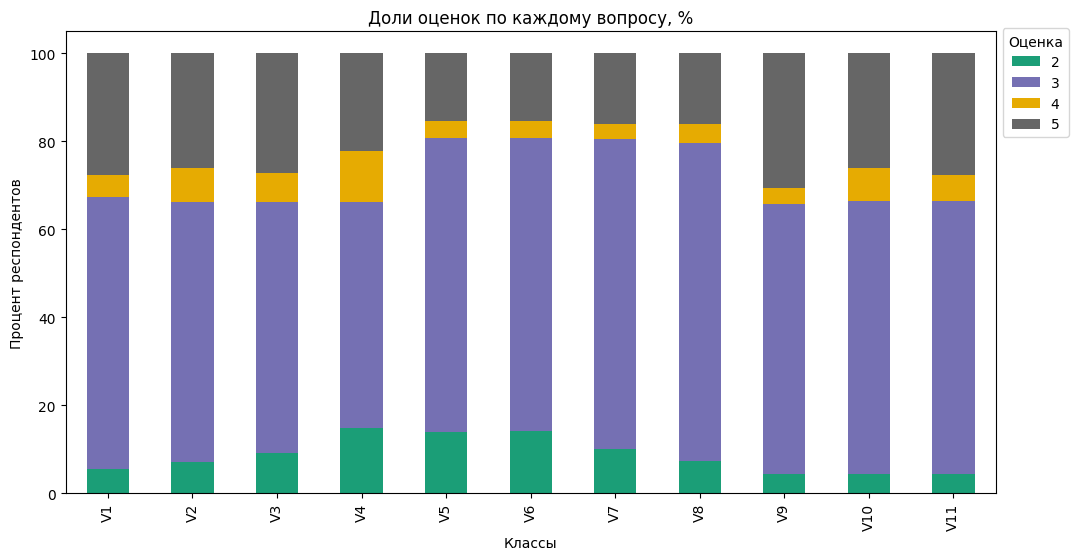

In [12]:
freq = df.apply(lambda x: x.value_counts(normalize=True)).fillna(0)*100
freq = freq.sort_index()
freq.round(1)
freq.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='Dark2'
)

plt.title("Доли оценок по каждому вопросу, %")
plt.ylabel("Процент респондентов")
plt.xlabel("Классы")
plt.legend(title="Оценка", bbox_to_anchor=(1, 1.022))
plt.show()


Как и ожидалось, люди ставили среднюю оценку чаще всего. В классах V4, V5 и V6 количество оценок `2` больше чем в других. Наиболее интересным из них ячляется `V4` (люди, которые потребляют леденцы, чтобы избавиться от неприятного вкуса во рту), т.к. в нём оценку `3` люди ставили меньше чем в каком либо другом класса, а также он имеет самое большое количество оценок `2` и сравнительно большую при этом оценку `5`, что означает большую уверенность конкретно для этой цели употребления. Нагляднее это можно увидеть, если построить плотность распределения (KDE):

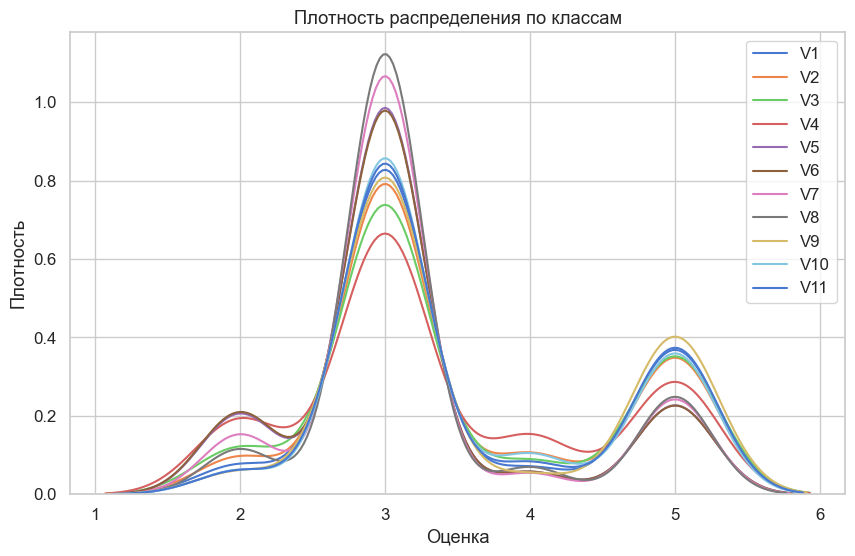

In [15]:
plt.figure(figsize=(10,6))
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    sns.kdeplot(df[col].dropna(), label=col, bw_adjust=1.0)
plt.title("Плотность распределения по классам")
plt.xlabel("Оценка")
plt.ylabel("Плотность")
plt.legend()
plt.show()

Ещё одна визуализация

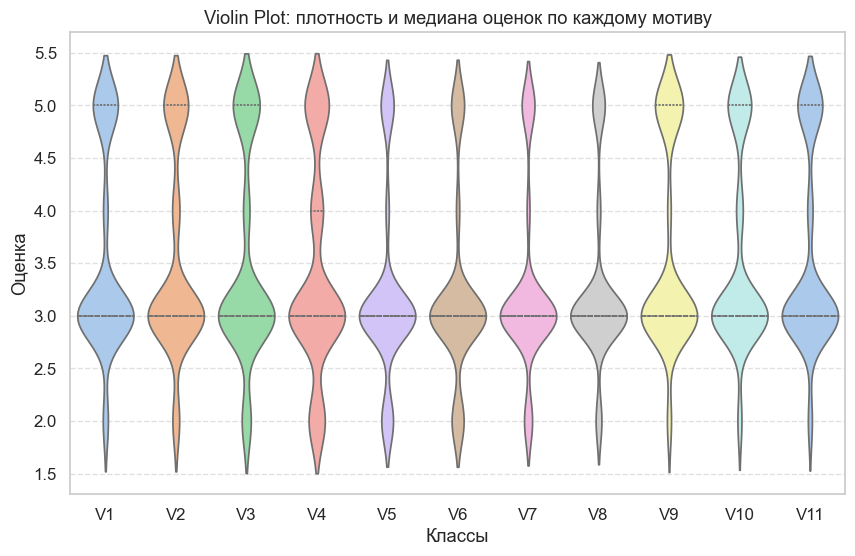

In [16]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df, palette="pastel", inner="quartile", bw=0.25)
plt.title("Violin Plot: плотность и медиана оценок по каждому мотиву")
plt.xlabel("Классы")
plt.ylabel("Оценка")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Визуализируем распределение данных на плоскости (PCA 2D), чтобы увидеть форму данных

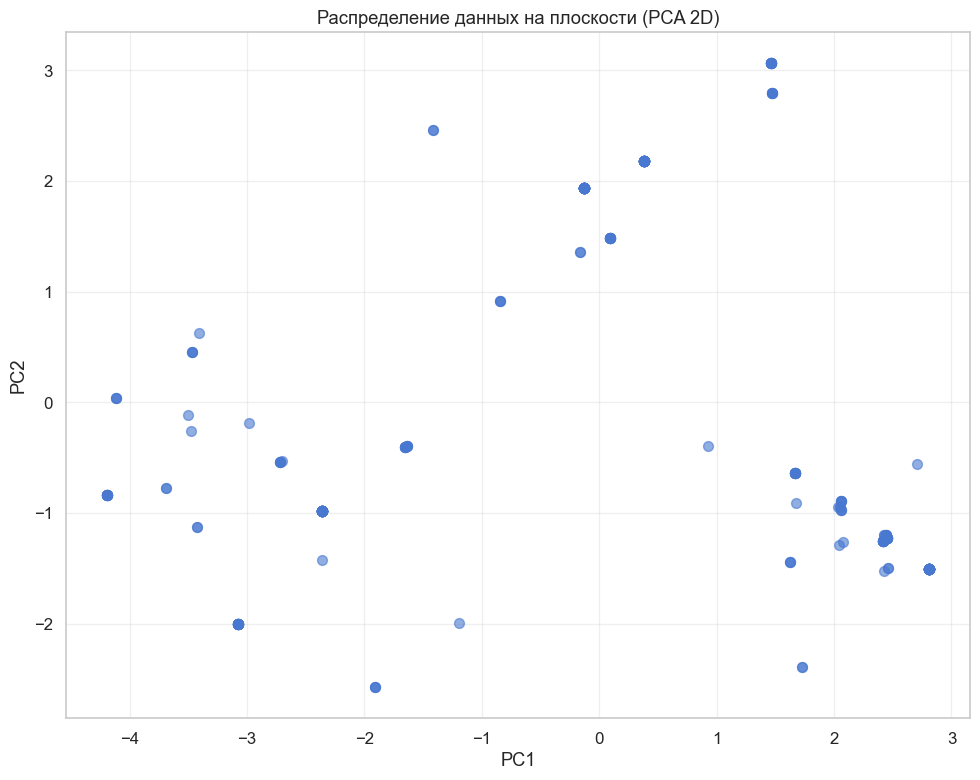

In [17]:
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(df.select_dtypes(include=np.number))

plt.figure(figsize=(10, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.6, s=50)
plt.title('Распределение данных на плоскости (PCA 2D)')
plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Здесь видно, что, скорее всего, будет только 3 основные группы кластеров. Однако, распределение представлено в виде проекции на плоскости, поэтому некоторые значения могут находиться далеко друг от друга в 3-мерном пространстве. Перейдём к самой кластеризации:

## Кластеризация

Признаки должны иметь одинаковый вклад, поэтому нормализуем данные

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.select_dtypes(include=np.number))
X = pd.DataFrame(X_scaled, columns=df.select_dtypes(include=np.number).columns)

Создадим функцию, которая сравненит качество кластеризации для различных значений числа `k` (диапазон определили выше).
  
Для каждой модели будем определять количество кластеров на основе 4 метрик:

- Elbow — оптимум в точке «излома» графика, где спад замедляется
- Calinski–Harabasz — оптимум соответствует максимальному значению функции
- Davies–Bouldin — оптимум соответствует минимальному значению функции
- Silhouette Score — наилучший результат при максимальном значении функции

Эта функция помогают визуально определить оптимальное число кластеров для выбранной модели.


In [19]:
def evaluate_clustering(X, model_name, model_func, K_range, **model_kwargs):
    print(model_name)
    X_np = X.values
    inertias, calinski, dbi, silhs = [], [], [], []

    for k in K_range:
        model = model_func(n_clusters=k, **model_kwargs).fit(X_np)
        if hasattr(model, 'labels_'):
                labels = model.labels_
        else:
            labels = model.predict(X_np)

        # inertia_ для KMeans готовая, для остальных считаем вручную
        if hasattr(model, 'inertia_'):
            inertia = model.inertia_
        else:
            centers = np.array([X_np[labels == i].mean(axis=0) for i in range(k)])
            inertia = sum(np.sum((X_np[labels == i] - centers[i])**2) for i in range(k))
        inertias.append(inertia)

        calinski.append(calinski_harabasz_score(X_np, labels))
        dbi.append(davies_bouldin_score(X_np, labels))
        silhs.append(silhouette_score(X_np, labels))

    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    titles = ['Elbow', 'Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette Score']
    data = [inertias, calinski, dbi, silhs]
    colors = ['blue', 'green', 'red', 'purple']

    for ax, title, y, color in zip(axs, titles, data, colors):
        ax.plot(K_range, y, '-o', color=color)
        ax.set_title(f'{title}')
        ax.set_xlabel('k')
        ax.set_ylabel('Score')

    axs[2].set_title(f'Davies-Bouldin')
    plt.show()

Выберем диапазон кластеров k=2..10:
- k=1 не имеет смысла (весь датасет — один кластер)
- k=2...10 — промежуток, который будем рассматривать
- при k > 10 кластеры становятся слишком мелкими и теряют значимость

In [20]:
K_range = list(range(2, 11))

Вызовем функцию выше для каждого из методов кластеризации: KMeans, GaussianMixture (GMM), Birch и AgglomerativeClustering

### Метод k-средних

Делит данные на k кластеров так, чтобы точки внутри кластера были как можно ближе друг к другу. Хорошо работает для «сферических» кластеров.

KMeans


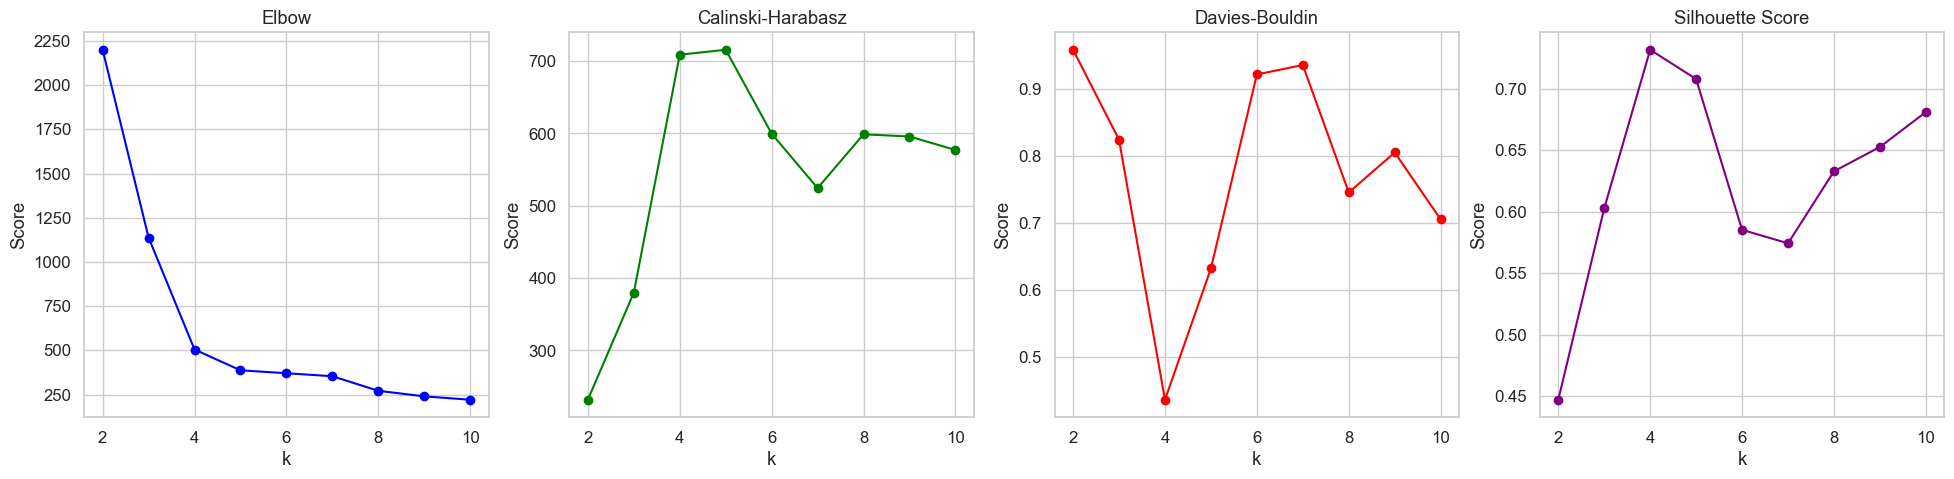

In [21]:
evaluate_clustering(X, 'KMeans', KMeans, K_range, random_state=42)

Здесь видно, что `Elbow`, `Davies-Bouldin` и `Silhouette Score` имеют чёткий оптимум в значении 4. `Calinski-Harabasz` показал менее точные результаты, т.к. ярковыраженного максимума функции нет, он распределён между значениями 4 и 5

### Гауссовская смесь

Предполагает, что данные состоят из смеси «колоколообразных» распределений. Каждому кластеру соответствует своё гауссовское распределение. Позволяет кластерам иметь разные формы и размеры, в отличие от KMeans, который ищет только центры

Здест есть несоклько типов ковариации:
- `full` - каждому кластеру своя полная ковариационная матрица (кластеры могут быть вытянутыми и наклонёнными, но легко переобучаются на маленьких данных)
- `tied` - все кластеры используют одну общую ковариационную матрицу (форма одинаковая для всех кластеров)
- `diag` - каждому кластеру своя диагональная ковариационная матрица (кластеры могут быть вытянутыми по осям, но не наклонёнными)
- `spherical` - каждый кластер - сфера с разным радиусом (подходит больше для круговых кластеров)

GaussianMixture (full)


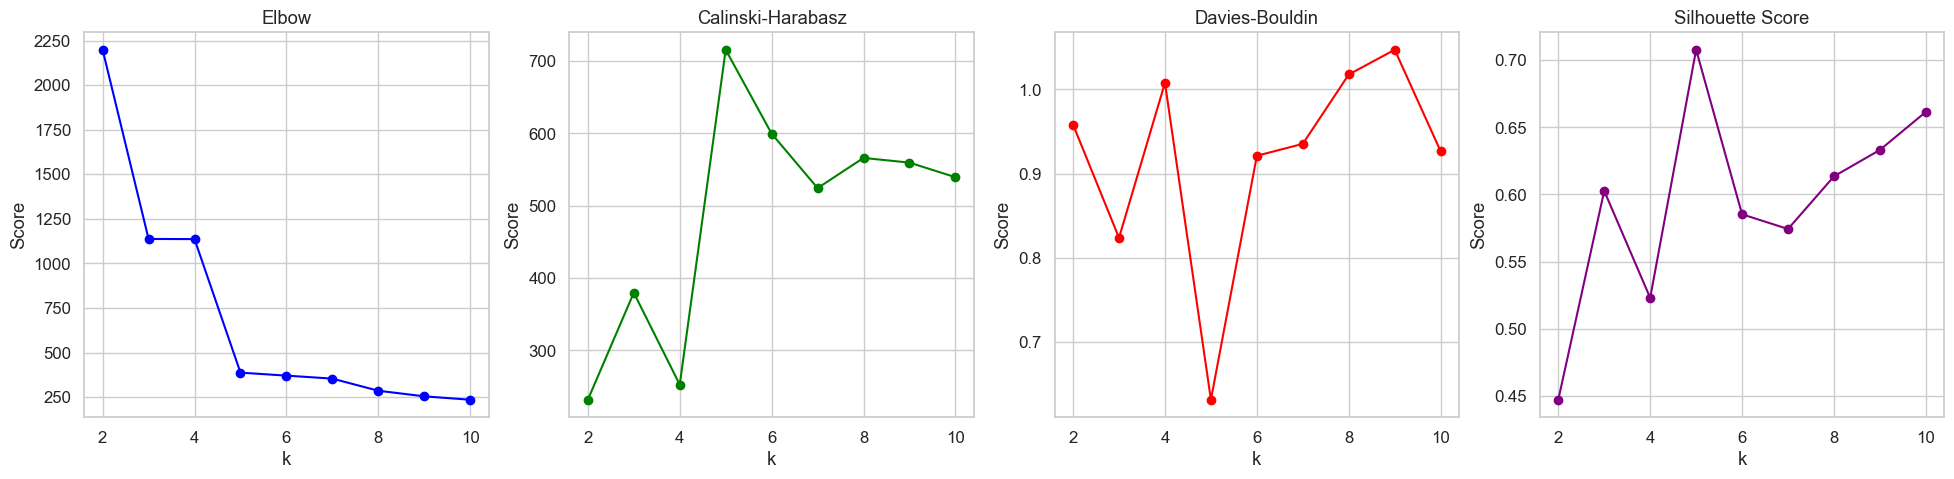

GaussianMixture (tied)


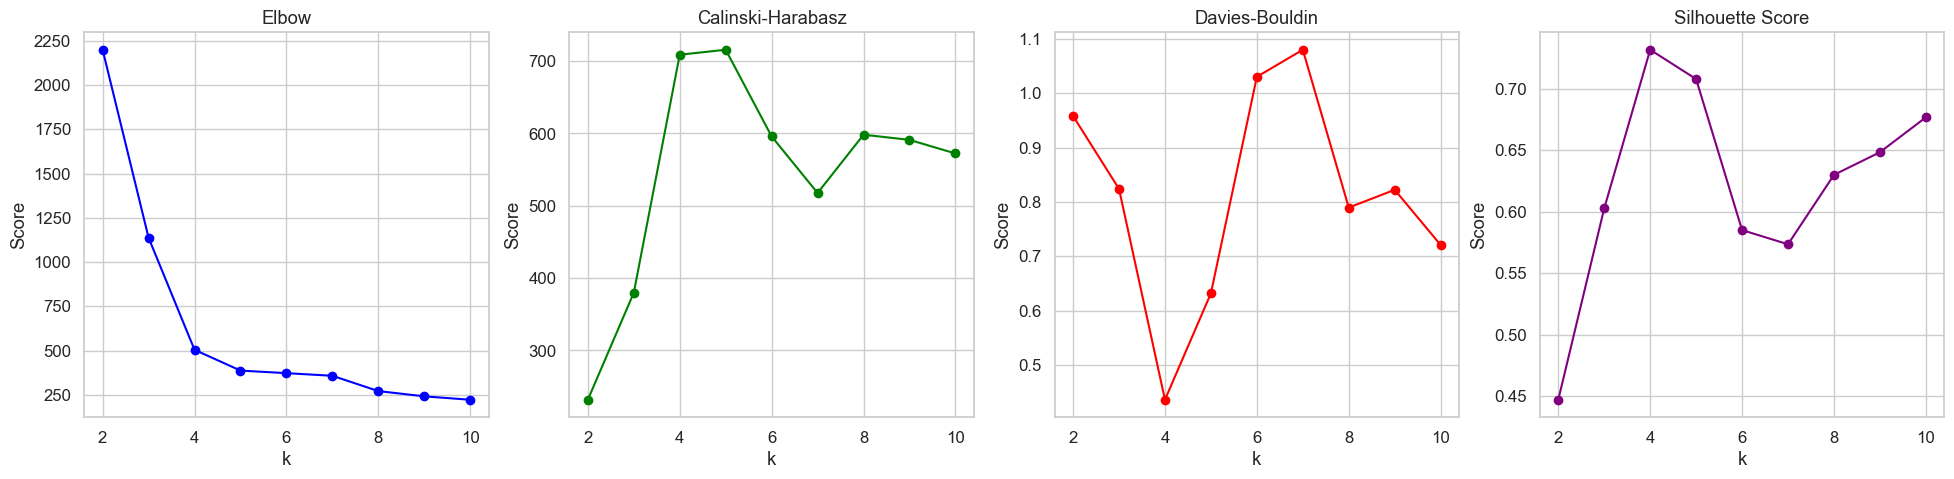

GaussianMixture (diag)


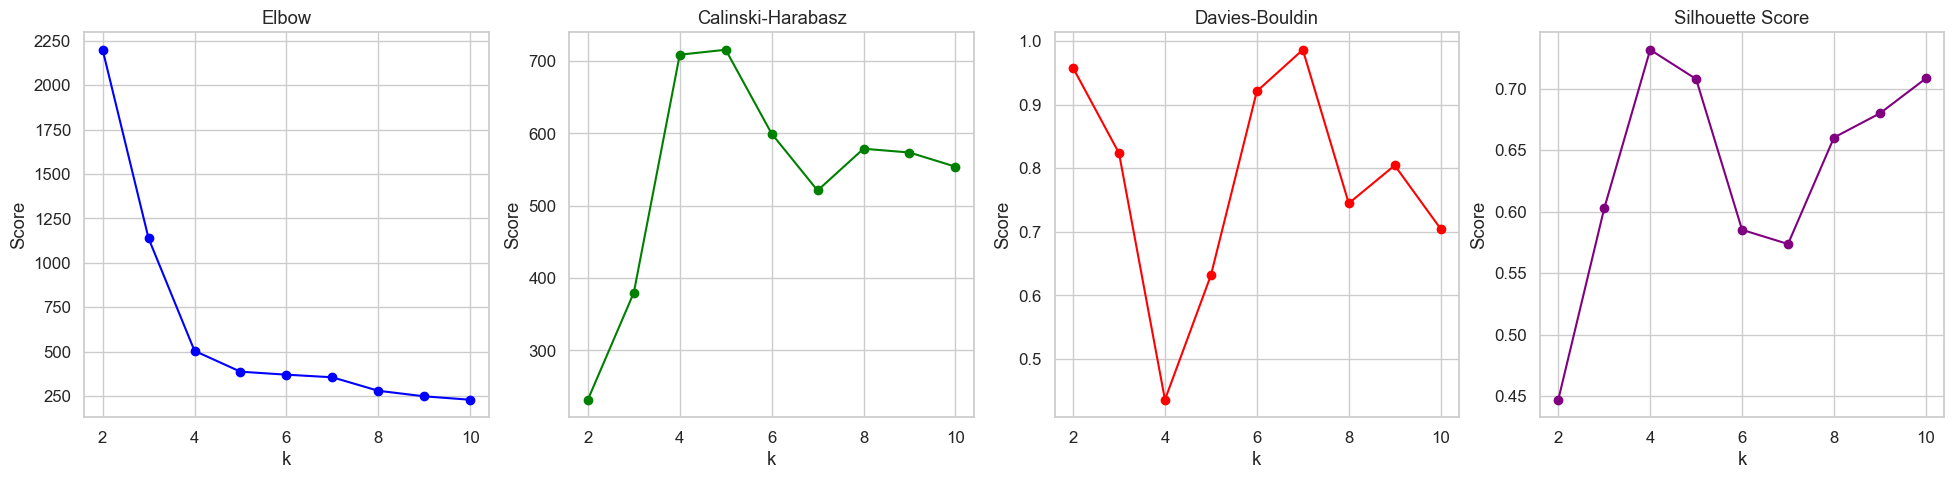

GaussianMixture (spherical)


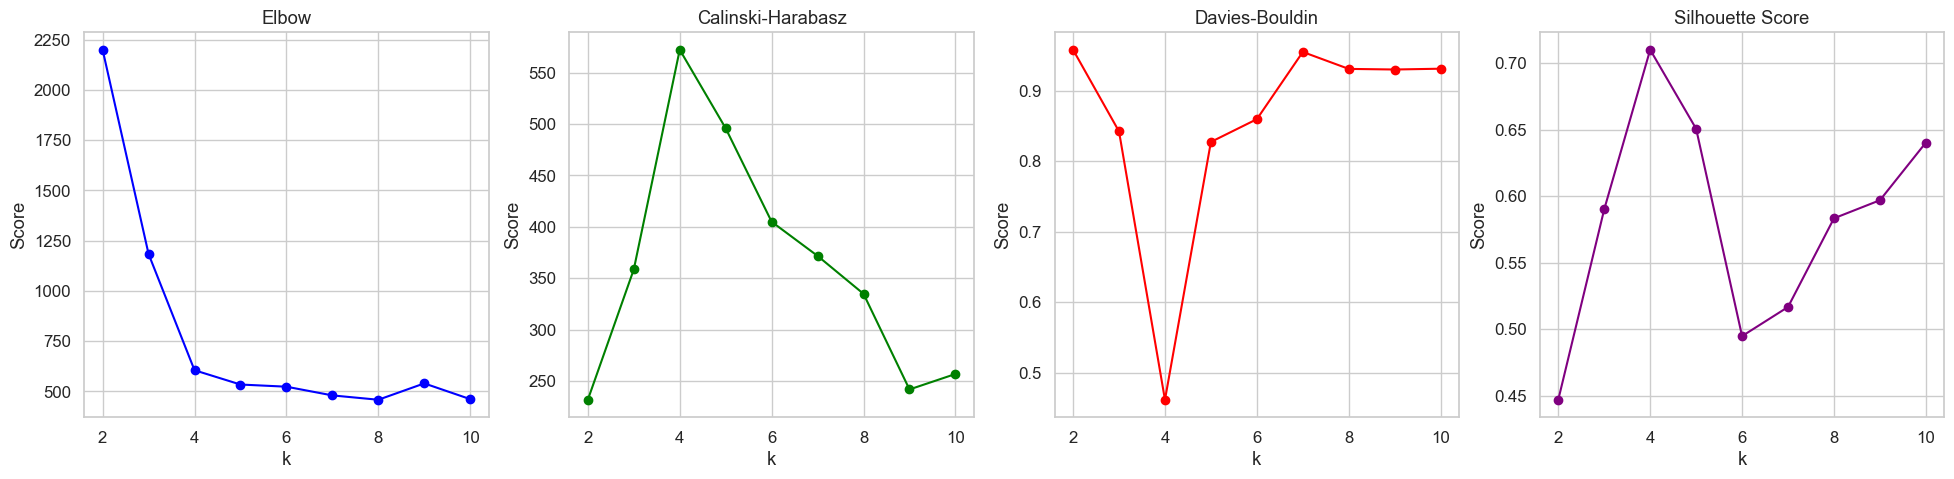

In [22]:
for g_type in ['full', 'tied', 'diag', 'spherical']:
    evaluate_clustering(
        X,
        f'GaussianMixture ({g_type})',
        lambda n_clusters, **kw: GaussianMixture(n_components=n_clusters, **kw),  # чтобы n_clusters соответствовал n_components
        K_range,
        random_state=42,
        covariance_type=g_type
    )

`spherical`, `diag` и `tied` показали 4 кластера. Эти варианты ограничивают форму кластеров, делая их «простыми» (сферы или диагональные эллипсы). Как и ожидалось, лучшее значение у `spherical` ковариации - есть одинаковый чёткий экстремум при 4 кластерах во всех случаях.

`full` позволяет каждому кластеру эллипсы любой формы и ориентации. На маленьких или средних данных это часто приводит к переобучению: GMM начинает подгонять «шума» в данных, пытается в точности повторить распределение каждой группы точек. В результате, модель может объединять точки в формы, которые не соответствуют реальным кластерам.

### Метод Birch

Объединяет точки по мере их близости, строя дерево кластеров, а не ищет центры кластеров, как KMeans. Хорошо подходит для компактных кластеров

Birch


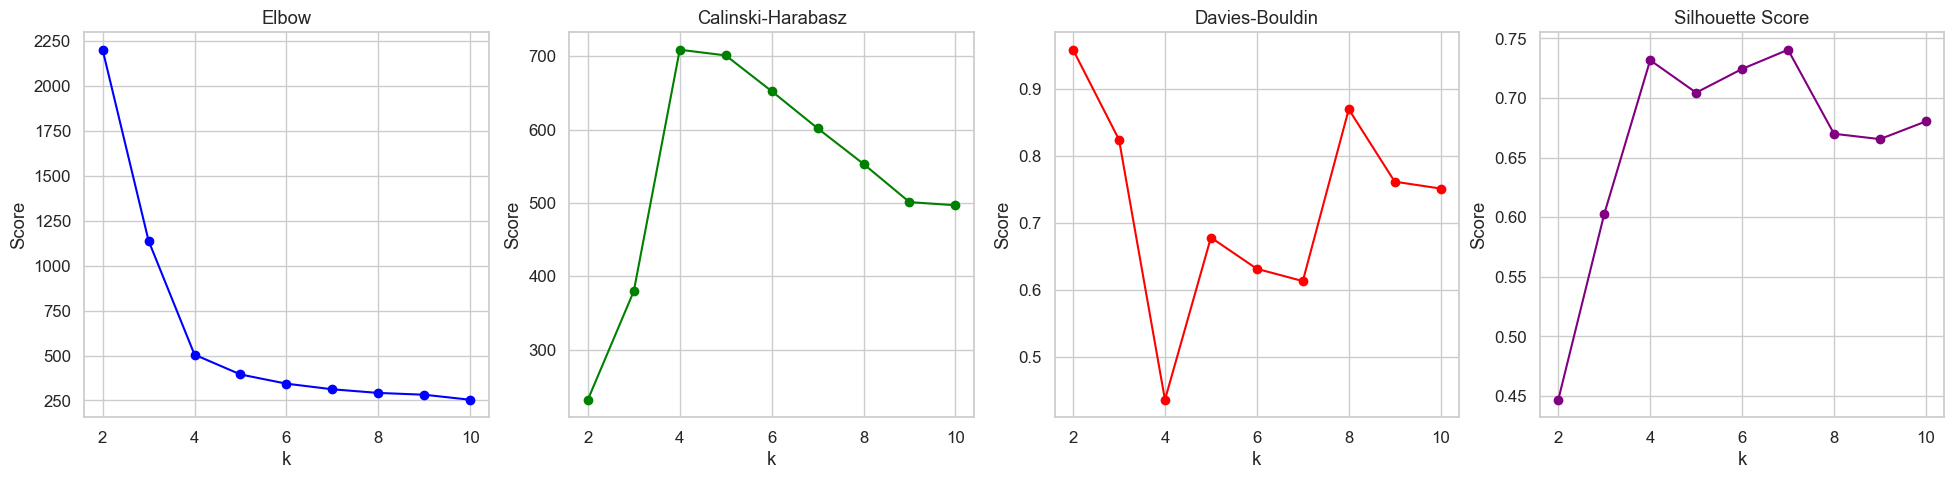

In [23]:
evaluate_clustering(
    X,
    'Birch',
    Birch,
    K_range
)

Оптимальным значением здесь также будет являться 4. Однако можно заметить, что на `Silhouette Score` выделяется ещё один оптимум при количестве кластеров = 7. Но в этом случае куаждый из кластеров будет слишком маленький и это, скорее, является просто особенностью `Silhouette Score`, который выделил подкластеры, которые в начале сформировал `Birch`

### Иерархическая кластеризация

Начинает с того, что каждая точка - отдельный кластер, а потом постепенно объединяет кластеры по мере их близости. В отличие от KMeans и GaussianMixture, не ищет центры кластеров, а строит дерево кластеров, которое можно визуализировать через дендрограмму. В отличие от Birch, здесь каждое слияние происходит последовательно, без предварительного построения подкластеров, что даёт более точную иерархию, но может быть медленнее на больших данных

Здесь рассмотрим несколько типов `linkage` (как мы измеряем расстояние между кластерами):
- `ward` - объединяет так, чтобы кластеры были максимально компактными (минимизирует внутрикластерную дисперсию)
- `complete` - смотрит на максимальное расстояние между точками кластеров (объединяет только сильно близкие кластеры)
- `average` - учитывает среднее расстояние между точками кластеров (баланс между Ward и Complete)
- `single` - учитывает минимальное расстояние между точками кластеров (может создавать «цепочки» точек и вытянутые кластеры)

Agglomerative (ward)


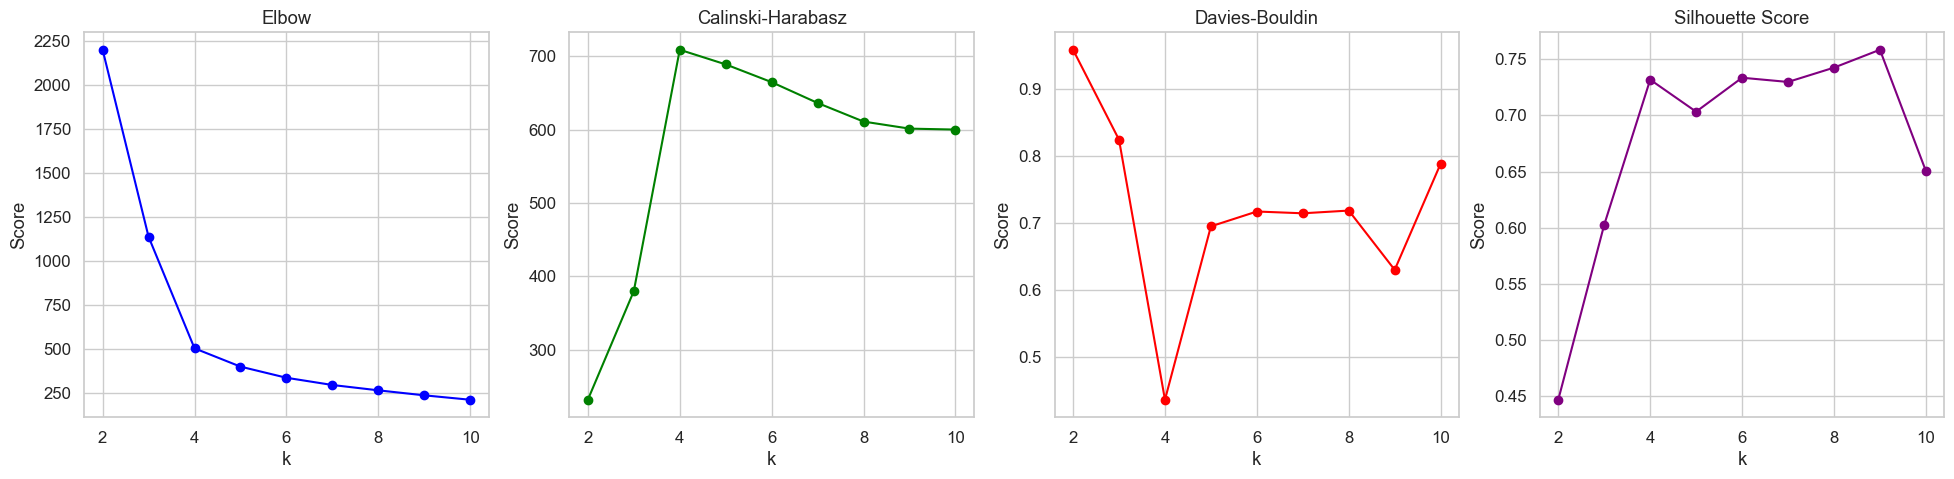

Agglomerative (complete)


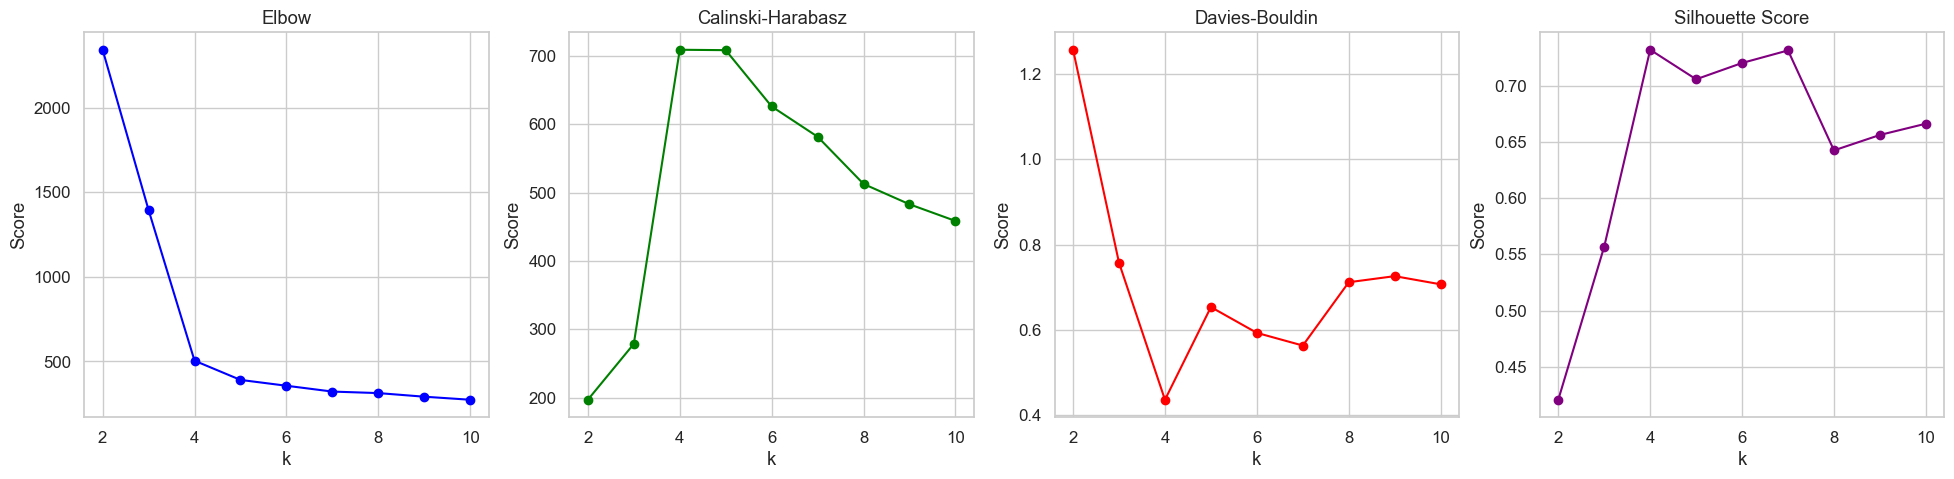

Agglomerative (average)


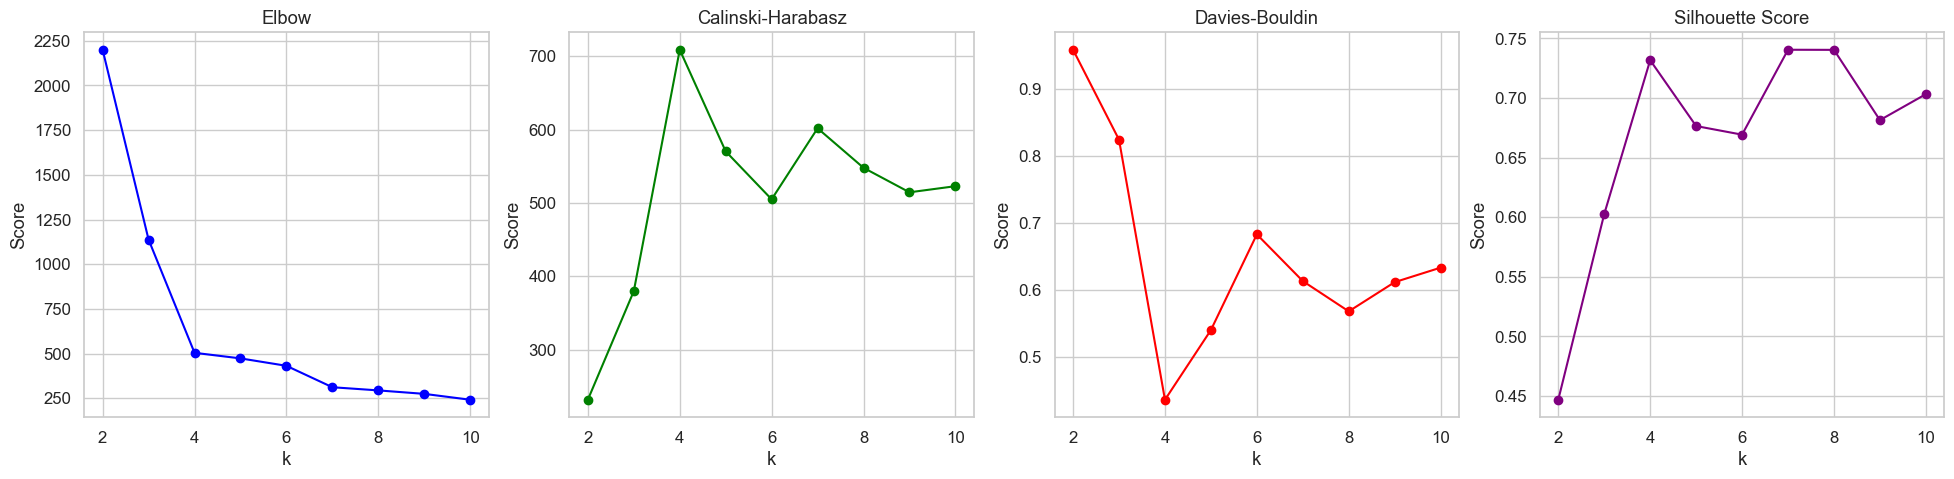

Agglomerative (single)


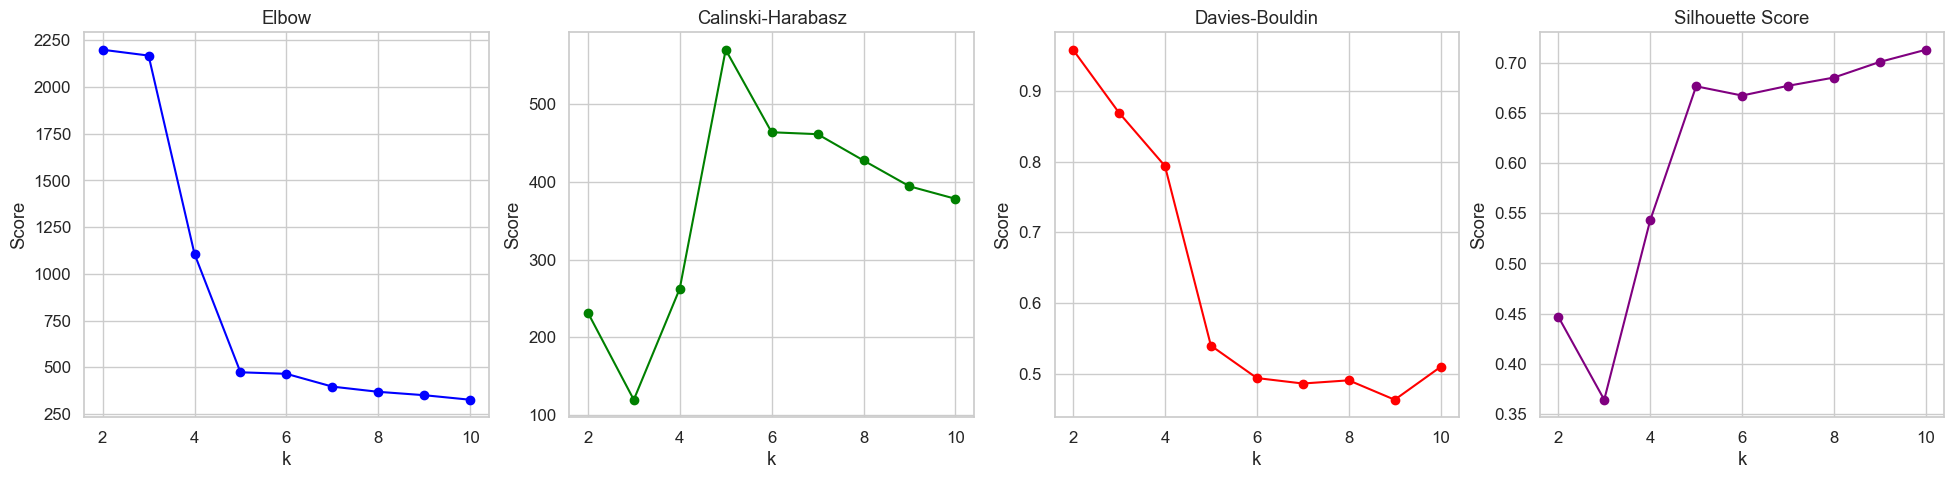

In [24]:
for a_type in ['ward', 'complete', 'average', 'single']:
    evaluate_clustering(
        X,
        f'Agglomerative ({a_type})',
        AgglomerativeClustering,
        K_range,
        linkage=a_type
    )

Оптимальным количество кластеров при использовании данного метода опять является 4.

Пояснения:
- `ward`, `complete` и `average` не позволяют образовываться длинным «цепочкам» точек, т.к. объединяют кластеры с учётом общей компактности (ward) или максимального/среднего расстояния между точками кластеров.
- `single` объединяет кластеры по минимальному расстоянию между точками. Это делает алгоритм чувствительным: даже если точки между кластерами далеко, одно соединение для близких точек может объединить их. Это можно увидеть и на графиках, т.к. оптимумом является 5, а в случае `Silhouette Score` количетсво оптимальных кластеров сильно завышено.

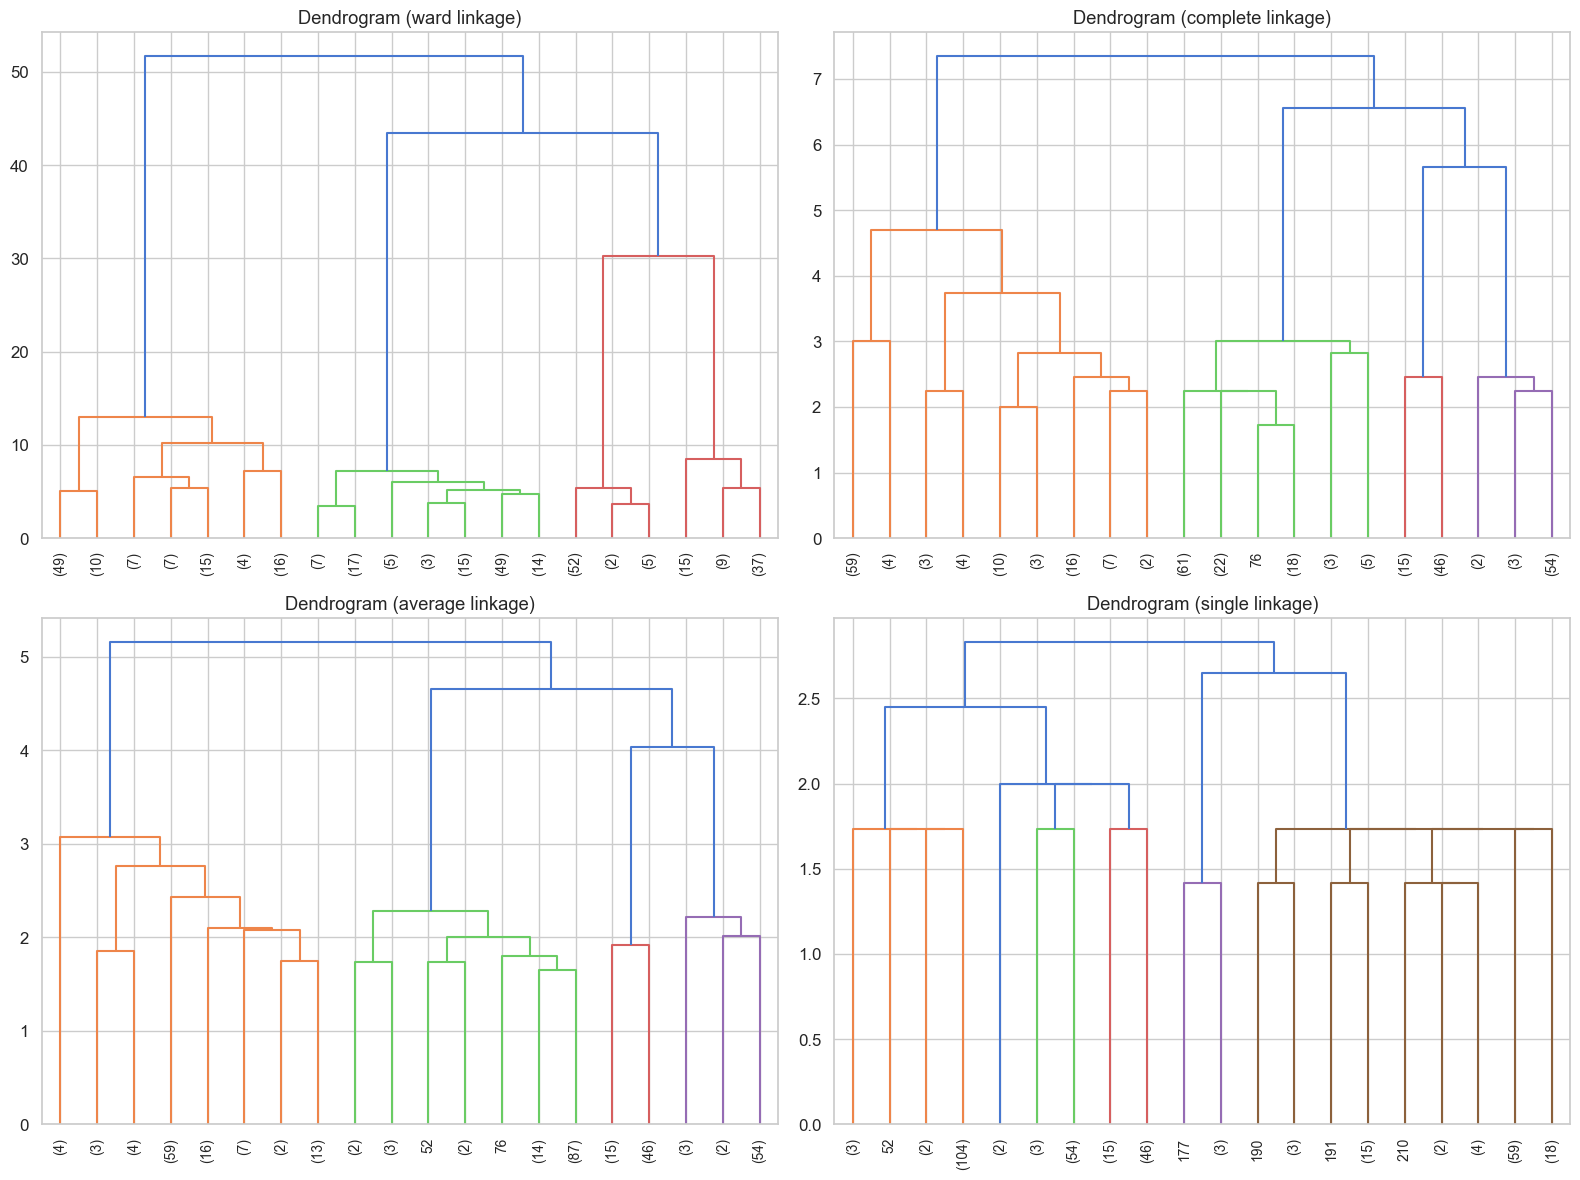

In [26]:
methods = ['ward', 'complete', 'average', 'single']

plt.figure(figsize=(16,12))

for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    linked = linkage(df, method=method)
    dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=10.)
    plt.title(f"Dendrogram ({method} linkage)")

plt.tight_layout()
plt.show()

## Оптимальное количество кластеров

Оптимальное количество кластеров = `4`. Для их определения лучше всего подошли следующие методы:
1) Гаусовская смесь (GaussianMixture) с типом ковариации `spherical`
2) KMean
3) Agglomerative с типом linkage `ward` и Birch (оба показали примерно одинаковую точность)

## Интерпритация полученных класетров

In [27]:
k_opt = 4

In [38]:
clustering_methods = {
    'GaussianMixture (spherical)': lambda X: GaussianMixture(n_components=k_opt, covariance_type='spherical', random_state=42).fit(X).predict(X),
    'KMeans': lambda X: KMeans(n_clusters=k_opt, random_state=42).fit(X).labels_,
    'Agglomerative (ward)': lambda X: AgglomerativeClustering(n_clusters=k_opt, linkage='ward').fit(X).labels_,
    'Birch': lambda X: Birch(n_clusters=k_opt).fit(X).labels_
}

Чтобы посмотреть какие данные входят в каждый из кластеров, построим столбчатую диаграмму `sns.barplot()` для каждого кластеров, где:

`x=cluster_means.columns` — это названия признаков

`y=cluster_means.loc[cluster]` — среднее значение признака для данного кластера

Ниже визуализация для всех методов, которые показали себя лучше всего

GaussianMixture (spherical)


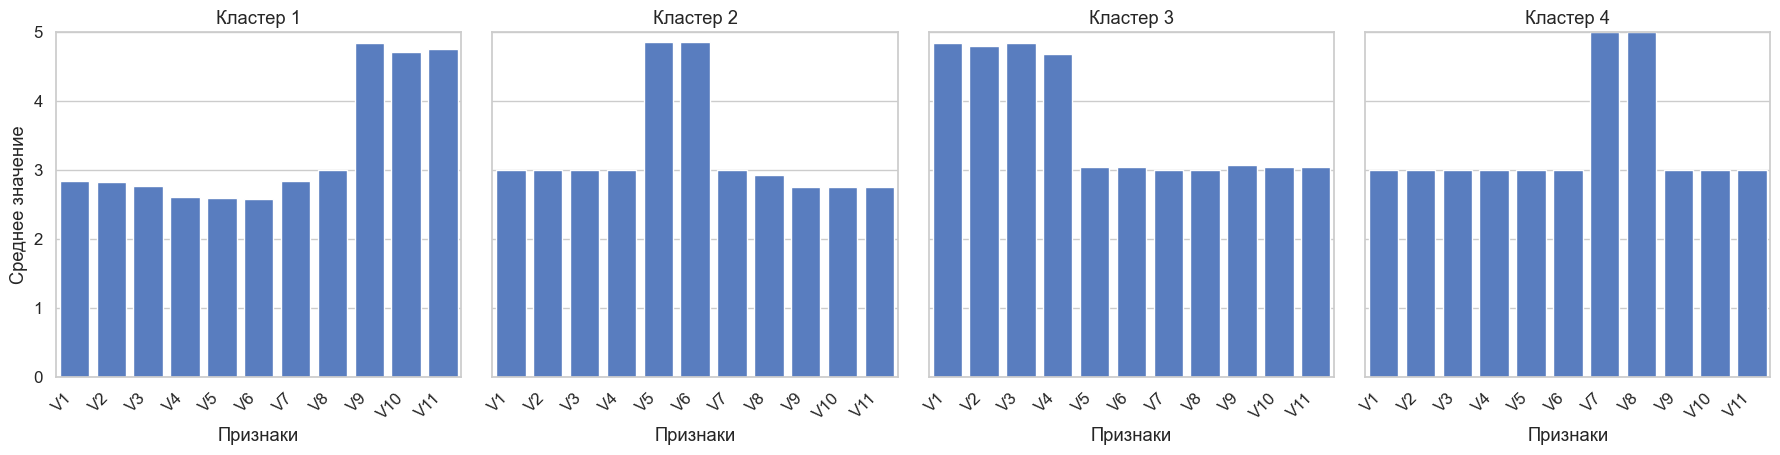

KMeans


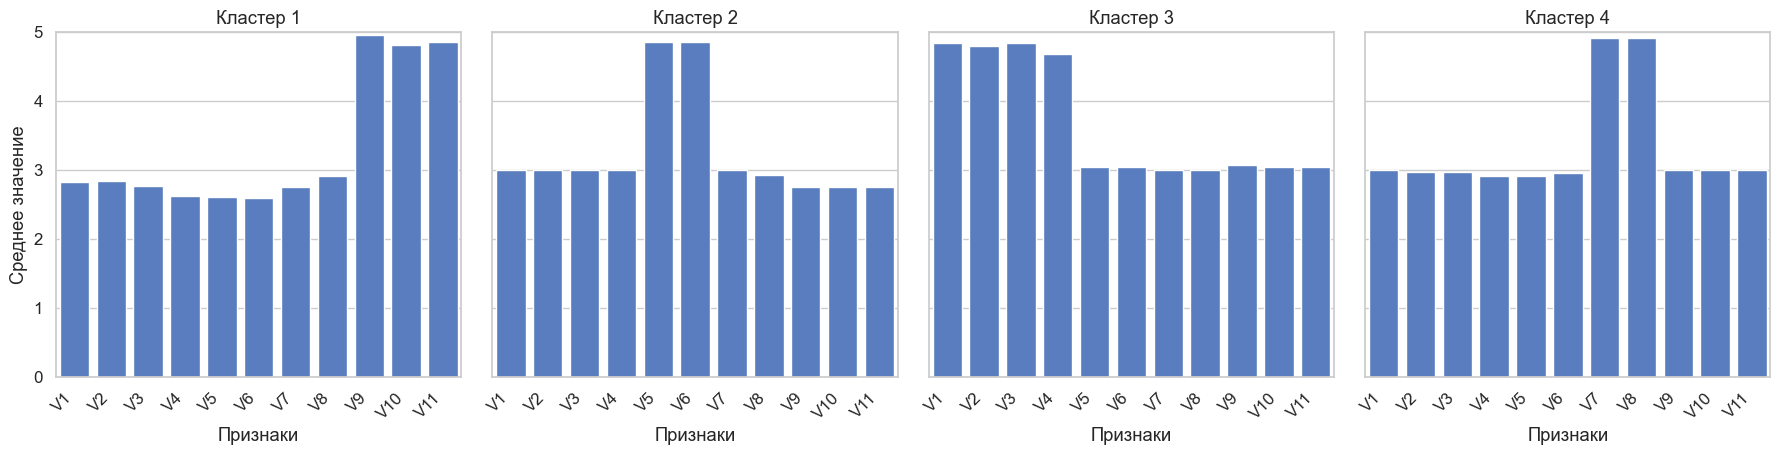

Agglomerative (ward)


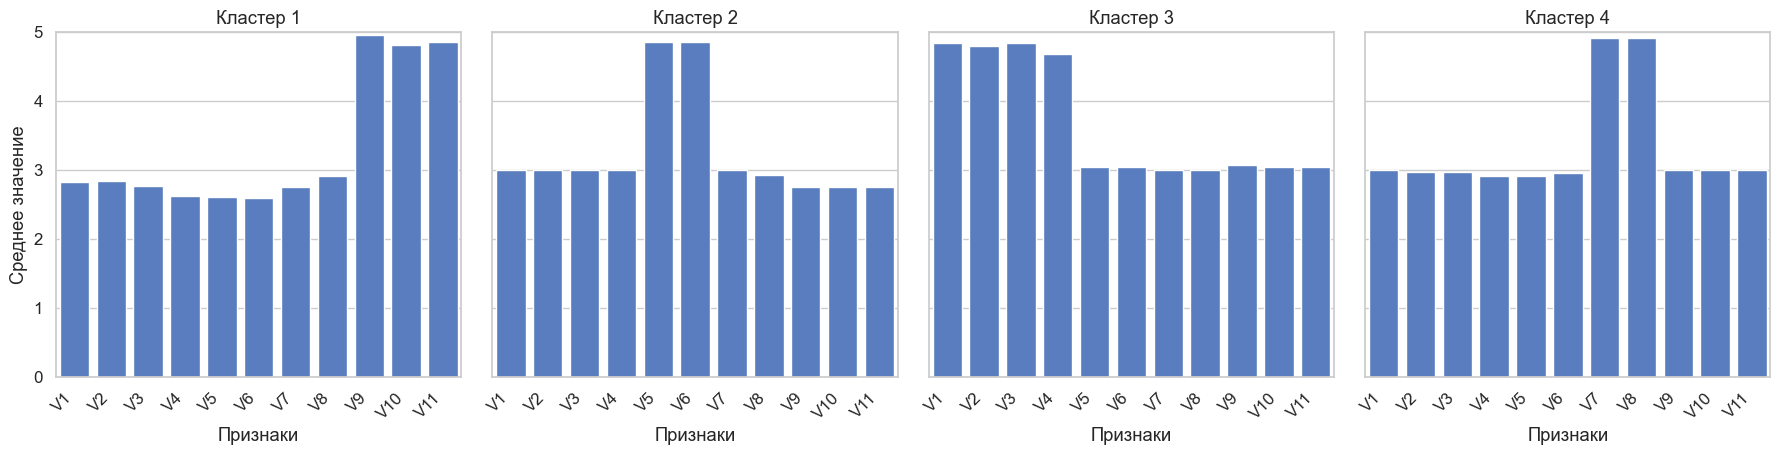

Birch


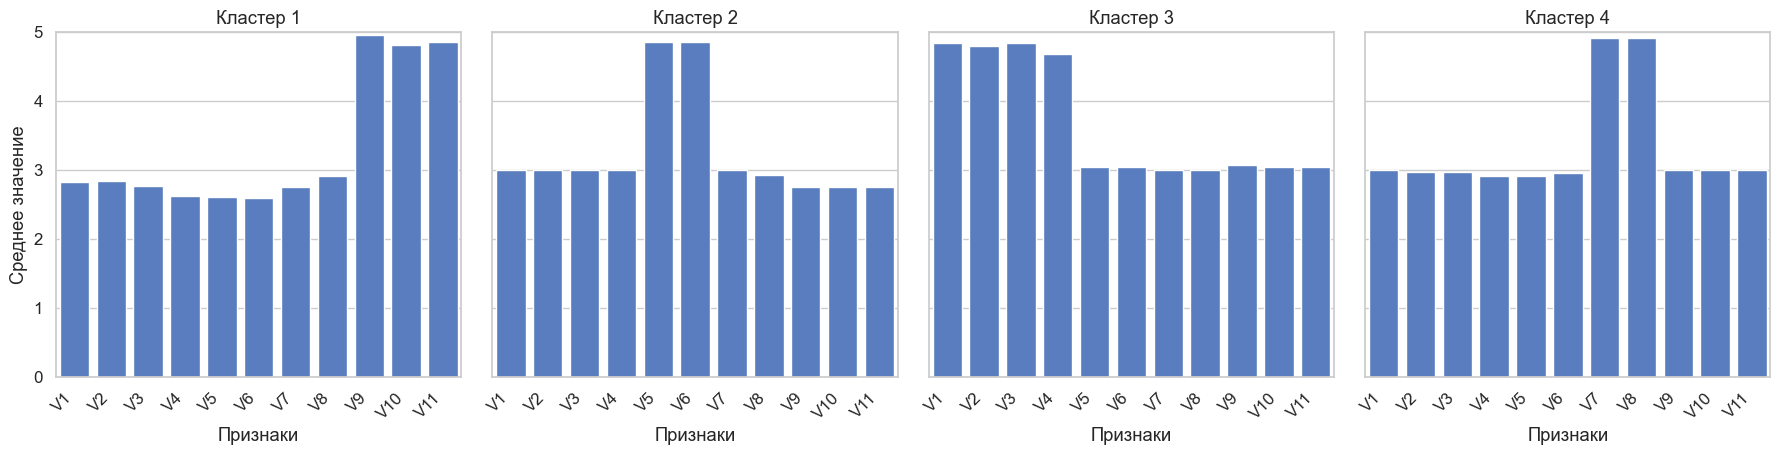

In [39]:
for method_name, func in clustering_methods.items():
    labels = func(X)  # метки кластеров
    df_clusters = df.copy()
    df_clusters['Cluster'] = labels

    cluster_means = df_clusters.groupby('Cluster').mean()

    fig, axs = plt.subplots(1, k_opt, figsize=(18,5), sharey=True)
    for i, cluster in enumerate(cluster_means.index):
        sns.barplot(x=cluster_means.columns, y=cluster_means.loc[cluster], ax=axs[i])
        axs[i].set_title(f'Кластер {cluster+1}')
        axs[i].set_xticklabels(cluster_means.columns, rotation=45, ha='right')
        axs[i].set_xlabel('Признаки')
        if i == 0:
            axs[i].set_ylabel('Среднее значение')
        axs[i].set_ylim(0, 5)
    print(method_name)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

На диаграммах выше видно, что везде распределение по классам одинаковое, что говорит о том, что все методы привели к схожим результатам. Теперь изучим подробно те классы, которые вошли в каждый из кластеров. Для удобства ниже выведу таблицу с исходными названиями классов:


| Переменная | Описание |
|------------|----------|
| V1  | Я потребляю леденцы, чтобы освежить дыхание |
| V2  | Я потребляю леденцы, чтобы чувствовать себя увереннее |
| V3  | Я потребляю леденцы, чтобы освежить полость рта |
| V4  | Я потребляю леденцы, чтобы избавиться от неприятного вкуса во рту |
| V5  | Я потребляю леденцы как заменитель других кондитерских изделий |
| V6  | Я потребляю леденцы, когда мне хочется чего-нибудь сладкого |
| V7  | Леденцы помогают мне сконцентрироваться |
| V8  | Я потребляю леденцы, чтобы отвлечься на несколько минут и подумать |
| V9  | Я потребляю леденцы для того, чтобы облегчить боль в горле |
| V10 | Я потребляю леденцы для того, чтобы избавиться от заложенности носа |
| V11 | Я потребляю леденцы для улучшения самочувствия |

Таким образом, обобщив данные с диаграмм и сведения о каждом из исходных классов, можно составить следующую таблицу:

| Кластер | Переменные | Описание |
|---------|------------|----------|
| 1       | V9, V10, V11 | Леденцы для облегчения боли в горле, снятия заложенности и улучшения самочувствия |
| 2       | V5, V6       | Леденцы как заменитель сладкого и когда хочется чего-нибудь сладкого |
| 3       | V1, V2, V3, V4 | Леденцы для свежего дыхания, уверенности и улучшения вкуса/полости рта |
| 4       | V7, V8       | Леденцы помогают сосредоточиться и отвлечься на несколько минут |

Это распределение выглядит логично и его удобно испольщовать для разделения покупателей на сегменты и улучшения последующих продаж

Теперь, чтобы визуализировать полученные кластеры, воспользуемся PCA для 3D проекции и интерактивными графиками через `plotly.express`. Для удобства точки раскрашены по кластерам ()

In [40]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

for method_name, func in clustering_methods.items():
    labels = func(X)
    df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    df_plot['Cluster'] = labels.astype(str)

    fig = px.scatter_3d(
        df_plot,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Cluster',
        color_discrete_map={'0':'red','1':'blue','2':'green','3':'orange'},
        symbol='Cluster',
        opacity=0.7,
        size_max=6
    )

    fig.update_layout(scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ))

    print(f'3D PCA projection of clusters: {method_name}')
    fig.show()

3D PCA projection of clusters: GaussianMixture (spherical)


3D PCA projection of clusters: KMeans


3D PCA projection of clusters: Agglomerative (ward)


3D PCA projection of clusters: Birch


## Ответ

Оптимальное количество кластеров = `4`. Для их определения лучше всего подошли следующие методы:
1) Гаусовская смесь (GaussianMixture) с типом ковариации `spherical`
2) KMean
3) Agglomerative с типом linkage `ward` и Birch (оба показали примерно одинаковую точность)

Для визуализации распределения классов по кластерам удобно исопльзовать столбчатые диаграммы, а для проверки того, насоклько хорошо распределены классы по кластерам в пространстве подойдёт визуализация с испольщованием интерактивных графиков `plotly.express`

Если интерпретировать полученные результаты, то было получено следующее распределение:

| Кластер | Переменные | Описание |
|---------|------------|----------|
| 1       | V9, V10, V11 | Леденцы для облегчения боли в горле, снятия заложенности и улучшения самочувствия |
| 2       | V5, V6       | Леденцы как заменитель сладкого и когда хочется чего-нибудь сладкого |
| 3       | V1, V2, V3, V4 | Леденцы для свежего дыхания, уверенности и улучшения вкуса/полости рта |
| 4       | V7, V8       | Леденцы помогают сосредоточиться и отвлечься на несколько минут |

## Источники

В ходе выполнения работы использовались дополнительные материалы, кроме лекций:

1. YouTube. [EDA, РАЗВЕДОЧНЫЙ И ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ | MATPLOTLIB, SEABORN](https://www.youtube.com/watch?v=uJpDzHGUamg)
2. YouTube. [Data Analyst Portfolio Project (Exploratory Data Analysis With Python Pandas)](https://www.youtube.com/watch?v=4sZFkPw87ng)
3. Medium. Nayeem, N. [Clustering with Confidence: A Practical Guide to Data Clustering in Python](https://medium.com/@nomannayeem/clustering-with-confidence-a-practical-guide-to-data-clustering-in-python-15d82d8a7bfb)
4. NEERC Wiki. [Оценка качества в задаче кластеризации](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.92.D0.BD.D0.B5.D1.88.D0.BD.D0.B8.D0.B5_.D0.BC.D0.B5.D1.80.D1.8B_.D0.BE.D1.86.D0.B5.D0.BD.D0.BA.D0.B8_.D0.BA.D0.B0.D1.87.D0.B5.D1.81.D1.82.D0.B2.D0.B0)  
5. YouTube. [Determine the right Number of Clusters | WSS | Elbow Method | Silhouette Score | Data Science](https://www.youtube.com/watch?v=DzrvLpxTxJw)  
6. YouTube. [Clustering with DBSCAN, Clearly Explained!!!](https://www.youtube.com/watch?v=RDZUdRSDOok)  